In [128]:
import os
import glob
import numpy as np
from scipy.io import wavfile
from scipy.signal import *
import re
import pandas as pd
import gc
import cv2
import librosa
import IPython.display as ipd

%matplotlib inline
import matplotlib.pyplot as plt

INPUT_DIR = '..//input//'
OUTPUT_DIR = '..//output//'
MAIN_DIR = 'C://data//tf_speech//'
TRAIN_DIR = MAIN_DIR + 'train//'
TRAIN_AUDIO_DIR = TRAIN_DIR + 'audio//'
BG_DIR = TRAIN_DIR + 'audio//_background_noise_//'
TEST_DIR = MAIN_DIR + 'test//audio//'

LABELS = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']
ID2NAME = {i: name for i, name in enumerate(LABELS)}
NAME2ID = {name: i for i, name in ID2NAME.items()}

LENGTH = 16000

RS = 17
EPS = 1e-12

SILENCE_PERCENT = .09

class AudioTransformer:
    def __init__(self):
        self.win_size = 256
        self.win_stride = 128
        self.time_shift_p = .8
        self.speed_tune_p = .8
        self.mix_with_bg_p = .8
        self.bg_noises = self.load_bg_noises()

    def load_bg_noises(self):
        bg_files = os.listdir(BG_DIR)
        bg_files.remove('README.md')
        bg_wavs = []
        for bg_file in bg_files:
            _, wav = wavfile.read(os.path.join(BG_DIR, bg_file))
            wav = wav.astype(np.float32) / np.iinfo(np.int16).max
            bg_wavs.append(wav)
        return bg_wavs

    def time_shift(self, wav):
        shift_range = .1 * LENGTH
        start_ = int(np.random.uniform(-shift_range, shift_range))
        if start_ >= 0:
            wav_time_shift = np.r_[wav[start_:], np.random.uniform(-0.001, 0.001, start_)]
        else:
            wav_time_shift = np.r_[np.random.uniform(-0.001, 0.001, -start_), wav[:start_]]
        return wav_time_shift

    def speed_tune(self, wav):
        speed_rate = np.random.uniform(0.7, 1.3)
        wav_speed_tune = cv2.resize(wav, (1, int(len(wav) * speed_rate))).squeeze()
        if len(wav_speed_tune) < LENGTH:
            pad_len = LENGTH - len(wav_speed_tune)
            wav_speed_tune = np.r_[np.random.uniform(-0.001, 0.001, int(pad_len/2)),
                                   wav_speed_tune,
                                   np.random.uniform(-0.001, 0.001, int(np.ceil(pad_len/2)))]
        else: 
            cut_len = len(wav_speed_tune) - LENGTH
            wav_speed_tune = wav_speed_tune[int(cut_len / 2) : int(cut_len / 2) + LENGTH]
        return wav_speed_tune

    def mix_with_bg(self, wav):
        bg = self.bg_noises[np.random.randint(len(self.bg_noises))]

        start_ = np.random.randint(bg.shape[0] - LENGTH)
        bg_slice = bg[start_ : start_ + LENGTH]
        wav_with_bg = wav * np.random.uniform(0.8, 1.2) + bg_slice * np.random.uniform(0, 0.1)

        return wav_with_bg

    def apply_augmentation(self, wav, label_id):
        if np.random.random() < self.time_shift_p:
            wav = self.time_shift(wav)
        if np.random.random() < self.speed_tune_p:
            wav = self.speed_tune(wav)
        if np.random.random() < self.mix_with_bg_p and ID2NAME[label_id] != 'silence':
            wav = self.mix_with_bg(wav)
        return wav

    def pad_audio(self, samples):
        if len(samples) >= LENGTH:
            return samples
        else:
            return np.pad(samples, pad_width=(LENGTH - len(samples), 0), mode='constant', constant_values=(0, 0))

    def process_wav_file(self, fname, label_id=None, mode='train', normalize=True):
        if fname == '':
            wav = np.zeros(shape=(LENGTH,))
        else:
            _, wav = wavfile.read(fname)
            wav = wav.astype(np.float32) / np.iinfo(np.int16).max

        if len(wav) > LENGTH:
            i = np.random.randint(0, len(wav) - LENGTH)
            wav = wav[i : i + LENGTH]
        elif len(wav) < LENGTH:
            wav = self.pad_audio(wav)

        if mode == 'train' and fname != '':
            wav = self.apply_augmentation(wav, label_id)

        specgram = spectrogram(wav, LENGTH, nperseg=self.win_size, noverlap=self.win_stride, nfft=self.win_size)
        spect = np.log(specgram[2].astype(np.float32) + EPS)

        spect2 = librosa.feature.melspectrogram(wav, sr=LENGTH, n_mels=129, hop_length=130, n_fft=480)
        spect2 = librosa.logamplitude(spect2)
        
#         dct_filters = librosa.filters.dct(n_filters=40, n_input=40)
#         mfcc = [np.matmul(dct_filters, x) for x in np.split(spect2, spect2.shape[1], axis=1)]
#         mfcc = np.hstack(mfcc)
#         mfcc = mfcc.astype(np.float32)
#         spect2 = mfcc

        
        if normalize:
            mean = spect.mean()
            std = spect.std()
            spect = (spect - mean) / (std + EPS)
            
            mean = spect2.mean()
            std = spect2.std()
            spect2 = (spect2 - mean) / (std + EPS)

        return wav,spect,spect2


(129, 124)


C:\Users\MAX\Anaconda2\envs\tf\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


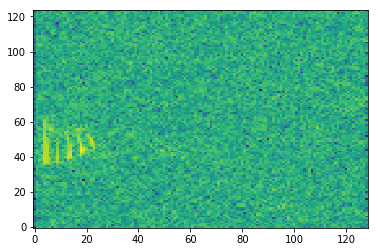

In [129]:
fname = TRAIN_AUDIO_DIR + 'yes//00f0204f_nohash_0.wav'
label_id = NAME2ID['yes']

at = AudioTransformer()

wav, spect, spect2 = at.process_wav_file(fname, label_id, normalize=True)

print(spect.shape)
plt.imshow(spect.T, aspect='auto', origin='lower')

ipd.Audio(wav, rate=LENGTH)

(129, 124)


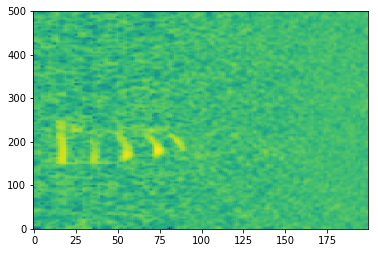

In [130]:
print(spect2.shape)
plt.imshow(cv2.resize(spect2.T, (200, 500)), aspect='auto', origin='lower')

In [58]:
spect.shape

(129, 124)

In [23]:
spect

array([[-24.60754967, -21.4617424 , -23.41512871, ..., -22.85722351,
        -22.48821259, -20.11151505],
       [-18.68375778, -18.94538879, -18.94822693, ..., -18.74130821,
        -17.41505814, -17.86852455],
       [-18.21614647, -21.87118912, -19.00293159, ..., -18.69885826,
        -18.91042137, -18.27503967],
       ..., 
       [-17.53343964, -17.07361031, -18.15437508, ..., -18.01972008,
        -17.36203003, -17.17260361],
       [-18.08003235, -18.44179726, -20.66132164, ..., -16.77859306,
        -16.08044052, -16.87237549],
       [-21.97215843, -22.05597115, -20.97244072, ..., -18.65390396,
        -21.29703522, -19.32117653]], dtype=float32)

In [107]:


_, wav = wavfile.read(fname)
ipd.Audio(wav, rate=LENGTH)

In [49]:
from sklearn.model_selection import train_test_split

def load_train_val_data():
    """ Return 2 lists of tuples:
    [(class_id, user_id, path), ...] for train
    [(class_id, user_id, path), ...] for validation
    """
    pattern = re.compile("C://(.+\\)?(\w+)\\([^_]+)_.+wav")
    all_files = glob.glob(os.path.join(TRAIN_AUDIO_DIR, '*/*wav'))

    speakers = []
    for fname in all_files:
        splits = fname.split('\\')
        if splits[-2] != '_background_noise_':
            speakers.append(splits[-1].split('_')[0])
    speakers = np.unique(speakers)
    train_speakers, val_speakers = train_test_split(speakers, test_size=0.3, random_state=RS)
    val_speakers, test_speakers = train_test_split(val_speakers, test_size=0.33, random_state=RS)
    
    train, val, test = [], [], []
    noise = []
    for fname in all_files:
        splits = fname.split('\\')
        label, uid = splits[-2], splits[-1].split('_')[0]
        if label == '_background_noise_':
            label = 'silence'
        if label not in LABELS:
            label = 'unknown'

        label_id = NAME2ID[label]

        sample = (label_id, uid, fname)
        if uid in val_speakers:
            val.append(sample)
        elif uid in test_speakers:
            test.append(sample)
        elif label == 'silence':
            noise.append(sample)
        else:
            train.append(sample)

    print('There are {} train, {} val, {} test samples'.format(len(train), len(val), len(test)))

    noise_type_percent = (SILENCE_PERCENT / (1 - SILENCE_PERCENT)) / len(noise)
    n_noise_type_train = int(noise_type_percent * len(train))
    n_noise_type_val = int(noise_type_percent * len(val))
    n_noise_type_test = int(noise_type_percent * len(test))

    for sample in noise:
        for i in range(n_noise_type_train):
            train.append(sample)
        for i in range(n_noise_type_val):
            val.append(sample)
        for i in range(n_noise_type_test):
            test.append(sample)

    print('There are {} train, {} val, {} test samples after adding SILENCE'.format(len(train), len(val), len(test)))
    
    train_labels = np.array([s[0] for s in train])
    val_labels = np.array([s[0] for s in val])
    test_labels = np.array([s[0] for s in val])
    train_parts = [len(train_labels[train_labels == l]) / len(train_labels) for l in range(len(LABELS))]
#     val_parts = [len(val_labels[val_labels == l]) / len(val_labels) for l in range(len(LABELS))]
#     test_parts = [len(test_labels[test_labels == l]) / len(test_labels) for l in range(len(LABELS))]
    print(train_parts)
    return train, val, test

In [50]:
trainset, valset, hoset = load_train_val_data()

There are 44929 train, 12928 val, 6864 test samples
There are 49369 train, 14206 val, 7542 test samples after adding SILENCE
[0.03370536166420223, 0.03323948226619944, 0.03344203852620065, 0.03315845976219895, 0.03269258036419616, 0.033502805404201016, 0.03315845976219895, 0.0327330916161964, 0.0340497073062043, 0.03327999351819968, 0.0899349794405396, 0.5771030403694626]


In [9]:
trainset, valset = load_train_val_data()
n_train = len(trainset)
n_val = len(valset)
    
print(n_train, n_val)

There are 59577 train and 5144 val samples
There are 64729 train and 5585 val samples after adding SILENCE
64729 5585


In [2]:
import os
import glob
import numpy as np
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy.signal import *
import re
import pandas as pd
import gc
import cv2

import tensorflow as tf
from keras import backend as K
import random as rn

INPUT_DIR = '..//input//'
OUTPUT_DIR = '..//output//'
MAIN_DIR = 'C://data//tf_speech//'
TRAIN_DIR = MAIN_DIR + 'train//'
TRAIN_AUDIO_DIR = TRAIN_DIR + 'audio//'
BG_DIR = TRAIN_DIR + 'audio//_background_noise_//'
TEST_DIR = MAIN_DIR + 'test//audio//'
PREDS_DIR = '..//output//preds//'

LABELS = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']
ID2NAME = {i: name for i, name in enumerate(LABELS)}
NAME2ID = {name: i for i, name in ID2NAME.items()}

LENGTH = 16000

RS = 17
EPS = 1e-12

SILENCE_PERCENT = .09

from sklearn.model_selection import train_test_split

def balance_unknown(data):
    labels = np.array([s[0] for s in data])
    labels_u_i = np.argwhere(labels == NAME2ID['unknown']).flatten()
    assert((labels[labels == NAME2ID['unknown']] == labels[labels_u_i]).all())

    u_part = len(labels[labels == NAME2ID['unknown']]) / len(labels)
    labels_u_i_not_needed = np.random.choice(labels_u_i, int(0.93 * len(labels_u_i)), replace=False)
    data = [x for i, x in enumerate(data) if i not in labels_u_i_not_needed]
    labels = np.array([s[0] for s in data])
    parts = [len(labels[labels == l]) / len(labels) for l in range(len(LABELS))]
    return data

def load_train_val_data_new():
    """ Return 2 lists of tuples:
    [(class_id, user_id, path), ...] for train
    [(class_id, user_id, path), ...] for validation
    """
    pattern = re.compile("C://(.+\\)?(\w+)\\([^_]+)_.+wav")
    all_files = glob.glob(os.path.join(TRAIN_AUDIO_DIR, '*/*wav'))

    speakers = []
    for fname in all_files:
        splits = fname.split('\\')
        if splits[-2] != '_background_noise_':
            speakers.append(splits[-1].split('_')[0])
    speakers = np.unique(speakers)
    train_speakers, val_speakers = train_test_split(speakers, test_size=0.2, random_state=RS)
    val_speakers, test_speakers = train_test_split(val_speakers, test_size=0.5, random_state=RS)
    
    train, val, test = [], [], []
    noise = []
    for fname in all_files:
        splits = fname.split('\\')
        label, uid = splits[-2], splits[-1].split('_')[0]
        if label == '_background_noise_':
            label = 'silence'
        if label not in LABELS:
            label = 'unknown'

        label_id = NAME2ID[label]

        sample = (label_id, uid, fname)
        if uid in val_speakers:
            val.append(sample)
        elif uid in test_speakers:
            test.append(sample)
        elif label == 'silence':
            noise.append(sample)
        else:
            train.append(sample)

    print('There are {} train, {} val, {} test samples'.format(len(train), len(val), len(test)))

    val = balance_unknown(val)
    test = balance_unknown(test)
    
    noise_type_percent = (SILENCE_PERCENT / (1 - SILENCE_PERCENT)) / len(noise)
    n_noise_type_train = int(noise_type_percent * len(train))
    n_noise_type_val = int(noise_type_percent * len(val))
    n_noise_type_test = int(noise_type_percent * len(test))

    for sample in noise:
        for i in range(n_noise_type_train):
            train.append(sample)
        for i in range(n_noise_type_val):
            val.append(sample)
        for i in range(n_noise_type_test):
            test.append(sample)

    print('There are {} train, {} val, {} test samples after adding SILENCE'.format(len(train), len(val), len(test)))
    train_labels = np.array([s[0] for s in train])
    val_labels = np.array([s[0] for s in val])
    test_labels = np.array([s[0] for s in val])
    train_parts = [len(train_labels[train_labels == l]) / len(train_labels) for l in range(len(LABELS))]
    val_parts = [len(val_labels[val_labels == l]) / len(val_labels) for l in range(len(LABELS))]
    test_parts = [len(test_labels[test_labels == l]) / len(test_labels) for l in range(len(LABELS))]
    print('TRAIN: ', train_parts)
    print('VAL: ', val_parts)
    print('HO: ', test_parts)
    
    return train, val, test

Using TensorFlow backend.


In [49]:
trainset, valset, hoset = load_train_val_data_new()

There are 51264 train, 6443 val, 7014 test samples
There are 56334 train, 2891 val, 3232 test samples after adding SILENCE
TRAIN:  [0.0329818582028615, 0.03340788866403948, 0.033265878510313485, 0.03314161962580325, 0.03276884297227252, 0.03319487343345049, 0.03339013739482373, 0.03289310185678276, 0.033532147548549725, 0.03335463485639223, 0.08999893492384706, 0.5780700820108637]
VAL:  [0.08405396056727776, 0.08197855413351782, 0.07990314769975787, 0.07782774126599792, 0.08405396056727776, 0.08267035627810446, 0.08197855413351782, 0.08163265306122448, 0.0774818401937046, 0.07990314769975787, 0.08924247665167762, 0.09927360774818401]
HO:  [0.08405396056727776, 0.08197855413351782, 0.07990314769975787, 0.07782774126599792, 0.08405396056727776, 0.08267035627810446, 0.08197855413351782, 0.08163265306122448, 0.0774818401937046, 0.07990314769975787, 0.08924247665167762, 0.09927360774818401]


In [4]:
def set_seeds():
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(RS)
    rn.seed(RS + 1000)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.set_random_seed(RS + 2000)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

In [109]:
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

from generators import *
from utilities import *
from models import *

set_seeds()
pred_files = ['val_vgg16_480_160', 'val_vgg16', 'val_resnet50', 'val_resnet50_224', 'val_incres_140',
              'val_incres_199', 'val_xception']


preds = np.array([pd.read_csv(os.path.join(PREDS_DIR, f + '.csv'), header=None).values for f in pred_files])
print(preds[0].shape)


trainset, valset, hoset = load_train_val_data()
if hoset is None:
    hoset = valset
labels = np.array([v[0] for v in hoset])
y_val = to_categorical(labels, num_classes = len(LABELS))
files = [v[2] for v in hoset]

preds = np.mean(preds, axis=0)
classes = np.argmax(preds, axis=1)
print(y_val.shape, preds.shape)
print('val log_loss {}; accuracy: {}'.format(log_loss(y_val, preds), accuracy_score(np.argmax(y_val, axis=1), classes)))
print(confusion_matrix(labels, classes))

for l in range(len(LABELS) - 1):
    classes[np.logical_and(classes == 11, preds[:,l] > 0.25)] = l
# classes[np.logical_and(classes != 10, preds[:,10] > 0.26)] = 10
# classes = np.argmax(preds, axis=1)
print(y_val.shape, preds.shape)
print('val log_loss {}; accuracy: {}'.format(log_loss(y_val, preds), accuracy_score(np.argmax(y_val, axis=1), classes)))
print(confusion_matrix(labels, classes))

(2794, 12)
There are 62144 train and 2577 val samples
There are 67520 train and 2794 val samples after adding SILENCE
(2794, 12) (2794, 12)
val log_loss 0.14348242429817004; accuracy: 0.9434502505368647
[[253   0   0   0   0   0   0   0   0   0   0   8]
 [  0 257   0   1   0   0   0   0   0   5   0   7]
 [  0   0 246   0   0   0   0   3   0   0   0  11]
 [  0   4   0 258   0   0   0   0   0   0   0   2]
 [  0   0   0   0 243   0   0   0   0   0   0   4]
 [  0   0   0   0   1 251   0   0   0   0   0   4]
 [  0   0   1   0   0   0 243   2   0   0   0  11]
 [  0   0   6   0   0   0   3 244   0   0   0   3]
 [  0   0   1   0   1   0   0   0 240   0   0   4]
 [  0   1   1   0   0   0   0   0   0 244   0  14]
 [  0   0   0   0   0   0   0   0   0   0 157  60]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]
(2794, 12) (2794, 12)
val log_loss 0.14348242429817004; accuracy: 0.9695776664280601
[[254   1   0   0   0   0   0   0   0   0   0   6]
 [  0 257   0   1   0   0   0   0   0   5   0   

In [34]:
test_pred_files = ['vgg16_480_160', 'vgg16_256_128', 'resnet50', 'resnet50_224', 'incres_140',
              'incres_199', 'xception']

test_preds = np.array([pd.read_csv(os.path.join(PREDS_DIR, f + '.csv'), header=None).values for f in test_pred_files])
print(test_preds[0].shape)
test_preds = np.mean(test_preds, axis=0)
test_classes = np.argmax(test_preds, axis=1)

(158538, 12)


In [95]:
print(test_classes[test_classes == 11].shape)
print(test_preds[test_preds[:,11] > 0.5].shape)
print(test_preds[np.logical_and(test_classes != 10, test_preds[:,10] > 0.26)].shape)

(97029,)
(90418, 12)
(1116, 12)


In [32]:
preds[np.logical_and(classes == 11, labels == 0)]

array([[  4.84856172e-01,   1.13028178e-04,   5.22518649e-05,
          2.78049540e-04,   4.14929360e-04,   1.50552275e-05,
          4.85852939e-06,   1.98075497e-05,   1.48043702e-04,
          5.86198851e-03,   1.06021933e-07,   5.08235712e-01],
       [  2.80174569e-02,   4.54189768e-02,   7.57260674e-02,
          4.50990615e-02,   5.37162758e-02,   4.21772581e-02,
          5.81358889e-02,   3.70377347e-02,   2.92074880e-02,
          6.06295200e-02,   1.34233370e-03,   5.23491957e-01],
       [  2.75875399e-02,   4.15209348e-02,   6.23770452e-02,
          4.29265790e-02,   4.36664500e-02,   3.69905678e-02,
          5.94986443e-02,   3.91946044e-02,   4.08257632e-02,
          6.87308828e-02,   7.93229687e-04,   5.35887774e-01],
       [  7.99187369e-02,   5.43842326e-02,   3.28709568e-02,
          3.27915203e-02,   4.21013034e-02,   3.67670206e-02,
          3.55528037e-02,   2.37131038e-02,   2.43803680e-02,
          6.05528349e-02,   1.81387633e-04,   5.76785730e-01],
    

In [87]:
preds[np.logical_and(classes != 10, preds[:,10] > 0.26)][:,10]

array([ 0.2698258 ,  0.32963553,  0.28376208,  0.30634118,  0.30343152,
        0.31495997,  0.3243305 ,  0.28135337,  0.26260075,  0.31817124,
        0.28261791,  0.30350437,  0.30326622,  0.28983512,  0.28560439,
        0.31522306,  0.33479675,  0.26292296,  0.29181212,  0.26383692,
        0.26519654,  0.29095295,  0.28306528,  0.2923489 ,  0.26309931,
        0.26199729,  0.29297464,  0.29746364,  0.30955327,  0.34605185,
        0.32764732,  0.33821081,  0.33731668,  0.3428302 ,  0.33918674,
        0.31729435,  0.30008675,  0.32674935,  0.34256672,  0.31401572,
        0.35634103,  0.30516345,  0.3289097 ,  0.36439762,  0.34367451,
        0.33330502,  0.34839705,  0.29776288,  0.33369319,  0.34011365,
        0.32846862,  0.33971262,  0.30010494,  0.35505724,  0.32846383,
        0.32983366,  0.34780957,  0.31691384])

In [85]:
preds[np.logical_and(classes == 11, labels == 10)][:,10:]

TypeError: 'int' object is not subscriptable

In [ ]:
pred_files = ['vgg16_480_160', 'vgg16_256_128', 'resnet50', 'resnet50_224', 'incres_140', 'incres_199',
              'xception', 'inception', 'vgg19', 'resnet50_fixed']

In [4]:
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm

from generators import *
from utilities import *
from models import *

import gc

from sklearn.metrics import log_loss, accuracy_score

def dump_preds(preds, preds_file):
    if not os.path.exists(PREDS_DIR):
        os.makedirs(PREDS_DIR)
    pd.DataFrame(preds).to_csv(os.path.join(PREDS_DIR, '_' + preds_file + '.csv'), index=False, header=False)

def make_val_preds(model_names, shapes, wdirs, batches, ttas, settings, preds_files):
    models = []
    for i in range(len(model_names)):
        model_f = get_model_f(model_names[i])
        opt = 'adam'
        models.append(get_model(model_f, shapes[i], opt))
        load_best_weights_min(models[-1], model_names[i], wdir=wdirs[i])

    trainset, valset, _ = load_train_val_data_with_unknown()
    labels = [v[0] for v in valset]
    y_val = to_categorical(labels, num_classes = len(LABELS))
    files = [v[2] for v in valset]

    audio_transformers = [AudioTransformer(settings[i]) for i in range(len(settings))]
    preds = [models[i].predict_generator(test_generator(files, batches[i], audio_transformers[i], ttas[i]),
                                         int(np.ceil(len(files) / (batches[i] / ttas[i]))), verbose=0)
                        for i in range(len(models))]

    for i in range(len(preds)):
        print('{} : loss = {}, acc = {}'.format(model_names[i],
                                                log_loss(y_val, preds[i]),
                                                accuracy_score(np.argmax(y_val, axis=1),
                                                               np.argmax(preds[i], axis=1))))
        dump_preds(preds[i], 'val_'+preds_files[i])

    preds_mean = np.mean(preds, axis=0)
    print('MEAN: val log_loss {}; accuracy: {}'.format(log_loss(y_val, preds_mean),
                                                       accuracy_score(np.argmax(y_val, axis=1),
                                                                      np.argmax(preds_mean, axis=1))))
    dump_preds(preds_mean, 'val_'+preds_files[-1])

if __name__ == '__main__':
    set_seeds()

    model_names = ['resnet50', 'resnet50']
    shapes = [(199, 199, 1), (224, 224, 1)]
    wdirs = ['resnet50_fixed', 'resnet50_224']
    files = ['resnet50_fixed', 'resnet50_224']
    batches = [16, 16,]
    ttas = [1, 1]

    s_vgg16_480_160 = dict()
    s_vgg16_480_160['win_size'] = 480
    s_vgg16_480_160['win_stride'] = 160
    s_vgg16_480_160['resize'] = False
    s_vgg16_480_160['resize_w'] = 199
    s_vgg16_480_160['resize_h'] = 199
    s_vgg16_480_160['time_shift_p'] = 0.8
    s_vgg16_480_160['speed_tune_p'] = 0.8
    s_vgg16_480_160['mix_with_bg_p'] = 0.8
    s_vgg16_480_160['spect'] = 'scipy'

    s_vgg16 = s_vgg16_480_160.copy()
    s_vgg16['win_size'] = 256
    s_vgg16['win_stride'] = 128
    
    s_resnet50 = s_vgg16.copy()
    s_resnet50['resize'] = True

    s_resnet50_224 = s_resnet50.copy()
    s_resnet50_224['resize_w'] = 224
    s_resnet50_224['resize_h'] = 224

    s_incres_140 = s_resnet50.copy()
    s_incres_140['resize_w'] = 140
    s_incres_140['resize_h'] = 140
    
    s_incres_199 = s_resnet50.copy()
    s_incres_199['resize_w'] = 199
    s_incres_199['resize_h'] = 199

    s_xcep = s_vgg16.copy()

    settings = [s_resnet50, s_resnet50_224]

    make_val_preds(model_names, shapes, wdirs, batches, ttas, settings, files)


looking for weights in resnet50_fixed
['0.153948-0.950966-032.h5']
loaded weights file:  resnet50_fixed\0.153948-0.950966-032.h5
looking for weights in resnet50_224
['0.161715-0.941303-005.h5']
loaded weights file:  resnet50_224\0.161715-0.941303-005.h5
{'5fadb538', '060cd039', '2296b1af', '54d9ccb5', '6d0ad764', '97ae8b25', '6c0f6493', 'cab100c9', '0e17f595', '8a5acefd', 'bfbd0e6b', 'db43cd03', 'ad63d93c', '53d5b86f', '44c201dd', 'b5d1e505', '3e2ba5f7', '8b775397', 'b00dff7e', 'e14a99a5', '91d5933a', '099d52ad', '2ce7534c', '826268f8', 'a6d586b7', 'ec21c46b', '6a27a9bf', '23ad12d8', 'b487da60', 'f17be97f', '90804775', '6940f7f3', '27b9a84f', 'd57febf0', '2643992f', 'da7689f1', 'd8d12371', 'edc53350', 'dc2222d7', 'bc196f81', '29b81b73', 'eee9b9e2', '1aed7c6d', '50f55535', 'b433332a', 'e6e29c47', '936de313', 'ec74a8a5', 'b0f24c9b', '7ca023e2', '409c962a', '364c0853', '2a89ad5c', '257e17e0', '591d32f3', '7eee5973', 'e6db3894', 'a7dd45cf', '1a9afd33', 'ab1299bb', '538e1856', 'd197e3ae', '

C:\Users\MAX\Anaconda2\envs\tf\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


resnet50 : loss = 0.09635073200674202, acc = 0.9664229623612239
resnet50 : loss = 0.0955351089463189, acc = 0.9623612239371785
MEAN: val log_loss 0.08952809360048256; accuracy: 0.967235310046033


## VALIDATION TEST

In [1]:
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from utilities import *
from keras.utils import to_categorical

trainset, valset, hoset = load_train_val_data()
if hoset is not None:
    valset = hoset
labels = np.array([v[0] for v in valset])
y_val = to_categorical(labels, num_classes = len(LABELS))

files = ['vgg16_480_160', 'vgg16_256_128', 'resnet50', 'resnet50_224', 'incres_140', 'incres_199',
              'xception', 'inception', 'vgg19', 'resnet50_fixed', 'resnet50_librosa']
val_preds = np.array([pd.read_csv(os.path.join(PREDS_DIR, 'val_' + f + '.csv'), header=None).values for f in files])

C:\Users\MAX\Anaconda2\envs\tf\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


{'91d5933a', '7eee5973', '66cff190', 'f34e6f44', 'e8c3c5ca', 'e6e29c47', 'ec21c46b', '27b9a84f', 'ab7b5acd', '3aa6f4e2', '44bc77f7', '65ec06e5', 'b6ebe225', '936de313', '48bfde8e', '6f5b4d3d', '2643992f', '44c201dd', '57cb3575', '750e3e75', 'eb0857c0', '8523766b', 'dbaf8fc6', 'b487da60', '105e72bb', 'd197e3ae', 'bdb26021', '989a2213', '28ef2a01', '86478fab', 'c013fe4d', '97ae8b25', 'fc94edb0', '88f8a99c', '2d056836', '409c962a', 'd57febf0', 'f2dd248e', '794cdfc5', 'edc53350', '41285056', '9d32f10a', '23ad12d8', '8910e5ef', '471a0925', 'bdee441c', '638685f2', 'bfbd0e6b', 'ab1299bb', '3ca784ec', 'cc6bae0d', '8b775397', '439c84f4', 'c50225fa', 'b7016c27', 'ec74a8a5', '4abefdf5', 'ccea893d', '53d5b86f', '50ed8a7b', 'a1dd919f', 'e6db3894', 'aa753bb9', 'd9462202', '962f27eb', '3b853f44', '6071a214', '060cd039', 'b433332a', '7ca023e2', 'e8e960fd', '541120c7', '099d52ad', 'b1edd209', 'a7dd45cf', '6a27a9bf', '2ce7534c', '3bdf05d3', '1657c9fa', 'b7a6f709', 'e54a0f16', 'c4e1f6e0', 'ad63d93c', 'fd

In [2]:
for preds, f in zip(val_preds, files):
    print('{}: loss = {}, acc = {}'.format(f, log_loss(y_val, preds), accuracy_score(labels, np.argmax(preds, axis=1))))

vgg16_480_160: loss = 0.21826091624918356, acc = 0.9402290622763063
vgg16_256_128: loss = 0.1945645486026613, acc = 0.9387974230493915
resnet50: loss = 0.16164297365717423, acc = 0.9441660701503222
resnet50_224: loss = 0.1640906783288074, acc = 0.9427344309234073
incres_140: loss = 0.1720269279002952, acc = 0.9352183249821046
incres_199: loss = 0.19450221010497384, acc = 0.9377236936292055
xception: loss = 0.1767493949369251, acc = 0.939513242662849
inception: loss = 0.17614492046985947, acc = 0.9448818897637795
vgg19: loss = 0.20974073561388726, acc = 0.933428775948461
resnet50_fixed: loss = 0.15798021570841136, acc = 0.9473872584108805
resnet50_librosa: loss = 0.20409208846143245, acc = 0.9377236936292055


In [13]:
files = ['vgg16_480_160', 'vgg16_256_128', 'resnet50', 'resnet50_224', 'incres_140', 'incres_199',
              'xception', 'inception', 'resnet50_fixed', 'resnet50_librosa']
val_preds = np.array([pd.read_csv(os.path.join(PREDS_DIR, 'val_' + f + '.csv'), header=None).values for f in files])
mean_preds = np.mean(val_preds, axis=0)
print('{}: loss = {}, acc = {}'.format(f, log_loss(y_val, mean_preds),
                                       accuracy_score(labels, np.argmax(mean_preds, axis=1))))

resnet50_librosa: loss = 0.14072544609529758, acc = 0.9448818897637795


In [14]:
confusion_matrix(labels, np.argmax(mean_preds, axis=1))

array([[254,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   7],
       [  0, 257,   0,   1,   0,   0,   0,   0,   0,   5,   0,   7],
       [  0,   0, 246,   0,   0,   0,   0,   3,   0,   0,   0,  11],
       [  0,   3,   0, 259,   0,   0,   0,   0,   0,   0,   0,   2],
       [  0,   0,   0,   0, 243,   0,   0,   0,   0,   0,   0,   4],
       [  0,   0,   0,   0,   1, 251,   0,   0,   0,   0,   0,   4],
       [  0,   0,   2,   0,   0,   0, 244,   2,   0,   0,   0,   9],
       [  0,   0,   9,   0,   0,   0,   3, 243,   0,   0,   0,   1],
       [  0,   0,   1,   0,   1,   0,   0,   0, 240,   0,   0,   4],
       [  0,   1,   1,   1,   0,   0,   0,   0,   0, 244,   0,  13],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 159,  58],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int64)

In [76]:
files = ['vgg16_480_160', 'vgg16_256_128', 'resnet50', 'resnet50_224', 'incres_140', 'incres_199',
              'xception', 'inception', 'resnet50_fixed', 'resnet50_librosa']
val_preds = np.array([pd.read_csv(os.path.join(PREDS_DIR, 'val_' + f + '.csv'), header=None).values for f in files])
mean_preds = np.mean(val_preds, axis=0)
pred_classes = np.argmax(mean_preds, axis=1)
for l in range(len(LABELS) - 1):
    pred_classes[np.logical_and(pred_classes == 11, mean_preds[:,l] > 0.25)] = l
print('{}: loss = {}, acc = {}'.format(f, log_loss(y_val, mean_preds),
                                       accuracy_score(labels, pred_classes)))

confusion_matrix(labels, pred_classes)


resnet50_librosa: loss = 0.14072544609529758, acc = 0.9681460272011453


array([[254,   1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   5],
       [  0, 257,   0,   1,   0,   0,   0,   0,   0,   5,   0,   7],
       [  0,   0, 249,   0,   0,   0,   0,   3,   0,   0,   0,   8],
       [  0,   3,   0, 260,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,   0,   0, 245,   0,   0,   0,   0,   0,   0,   2],
       [  0,   0,   0,   0,   1, 252,   0,   0,   0,   0,   0,   3],
       [  0,   0,   2,   0,   0,   0, 245,   2,   0,   0,   0,   8],
       [  0,   0,   9,   0,   0,   0,   3, 243,   0,   0,   0,   1],
       [  0,   0,   1,   0,   1,   0,   0,   0, 241,   0,   0,   3],
       [  0,   1,   1,   1,   0,   0,   0,   0,   0, 244,   0,  13],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 215,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int64)

In [79]:
files = ['vgg16_480_160', 'vgg16_256_128', 'resnet50', 'resnet50_224', 'incres_140', 'incres_199',
              'xception', 'inception', 'resnet50_fixed', 'resnet50_librosa']
val_preds = np.array([pd.read_csv(os.path.join(PREDS_DIR, 'val_' + f + '.csv'), header=None).values for f in files])
mean_preds = np.mean(val_preds, axis=0)
pred_classes = np.argmax(mean_preds, axis=1)
for l in range(len(LABELS) - 1):
    cond = np.logical_and(pred_classes == 11, mean_preds[:,l] > 0.25)
    mean_preds[np.where(cond)[0], 11] = 0.0
#     pred_classes[np.logical_and(pred_classes == 11, preds[:,l] > 0.3)] = l
pred_classes = np.argmax(mean_preds, axis=1)
print('{}: loss = {}, acc = {}'.format(f, log_loss(y_val, mean_preds),
                                       accuracy_score(labels, pred_classes)))

confusion_matrix(labels, pred_classes)


resnet50_librosa: loss = 0.12705379777634246, acc = 0.9681460272011453


array([[254,   1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   5],
       [  0, 257,   0,   1,   0,   0,   0,   0,   0,   5,   0,   7],
       [  0,   0, 249,   0,   0,   0,   0,   3,   0,   0,   0,   8],
       [  0,   3,   0, 260,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,   0,   0, 245,   0,   0,   0,   0,   0,   0,   2],
       [  0,   0,   0,   0,   1, 252,   0,   0,   0,   0,   0,   3],
       [  0,   0,   2,   0,   0,   0, 245,   2,   0,   0,   0,   8],
       [  0,   0,   9,   0,   0,   0,   3, 243,   0,   0,   0,   1],
       [  0,   0,   1,   0,   1,   0,   0,   0, 241,   0,   0,   3],
       [  0,   1,   1,   1,   0,   0,   0,   0,   0, 244,   0,  13],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 215,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int64)

In [71]:
files = ['vgg16_480_160', 'vgg16_256_128', 'resnet50', 'resnet50_224', 'incres_140', 'incres_199',
              'xception', 'inception', 'resnet50_fixed', 'resnet50_librosa']
val_preds = np.array([pd.read_csv(os.path.join(PREDS_DIR, 'val_' + f + '.csv'), header=None).values for f in files])
mean_preds = np.mean(val_preds, axis=0)
pred_classes = np.argmax(mean_preds, axis=1)

cond = np.logical_and(pred_classes == 11, preds[:,10] > 0.3)
print(mean_preds[cond][:,10])
mean_preds[np.where(cond)[0],10] = 0.0
print(mean_preds[cond][:,10])

[0.06525322 0.31216691 0.36455184 0.24018613 0.30280273 0.36900343
 0.35658546 0.2756928  0.30287207 0.28491242 0.27410642 0.31223952
 0.27218509 0.34150805 0.253962   0.34571146 0.2954561  0.29892514
 0.26476207 0.27379655 0.27849237 0.3202768  0.35169703 0.33960811
 0.34337149 0.34491805 0.34508276 0.32497092 0.33593895 0.34623419
 0.36580923 0.35972165 0.3418547  0.36085918 0.33891083 0.34587698
 0.33771519 0.34339429 0.33538063 0.34719298 0.28058259 0.36784628
 0.3491062  0.33524997 0.36322937]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


array([0.06525322, 0.31216691, 0.36455184, 0.24018613, 0.30280273,
       0.36900343, 0.35658546, 0.2756928 , 0.30287207, 0.28491242,
       0.27410642, 0.31223952, 0.27218509, 0.34150805, 0.253962  ,
       0.34571146, 0.2954561 , 0.29892514, 0.26476207, 0.27379655,
       0.27849237, 0.3202768 , 0.35169703, 0.33960811, 0.34337149,
       0.34491805, 0.34508276, 0.32497092, 0.33593895, 0.34623419,
       0.36580923, 0.35972165, 0.3418547 , 0.36085918, 0.33891083,
       0.34587698, 0.33771519, 0.34339429, 0.33538063, 0.34719298,
       0.28058259, 0.36784628, 0.3491062 , 0.33524997, 0.36322937])

## confussion

In [ ]:
from sklearn.metrics import confusion_matrix

trainset, valset, hoset = load_train_val_data()
if hoset is not None:
    valset = hoset
labels = np.array([v[0] for v in valset])

files = ['vgg16_480_160', 'vgg16', 'resnet50', 'resnet50_224', 'incres_140',
             'incres_199', 'xception', 'mean[2v+2r+2ir+x]']
val_preds = np.array([pd.read_csv(os.path.join(PREDS_DIR, 'val_' + f + '.csv'), header=None).values for f in files])

In [4]:
mean_preds = np.argmax(val_preds[-1], axis=1)

confusion_matrix(labels, mean_preds)

array([[252,   1,   0,   0,   1,   0,   0,   0,   0,   0,   0,   7],
       [  0, 257,   0,   1,   0,   0,   0,   0,   0,   5,   0,   7],
       [  0,   0, 246,   0,   0,   0,   0,   4,   0,   0,   0,  10],
       [  0,   3,   0, 260,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,   0,   0, 245,   0,   0,   0,   0,   0,   0,   2],
       [  0,   0,   0,   0,   1, 251,   0,   0,   0,   0,   0,   4],
       [  0,   0,   2,   0,   0,   0, 241,   3,   0,   0,   0,  11],
       [  0,   0,  10,   0,   1,   0,   1, 243,   0,   0,   0,   1],
       [  0,   0,   1,   0,   1,   0,   0,   0, 242,   0,   0,   2],
       [  0,   3,   1,   5,   0,   0,   0,   0,   0, 239,   0,  12],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 171,  46],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=int64)

In [12]:
files = np.array([v[2] for v in valset])
bad_files = files[np.logical_and(labels == 10, mean_preds == 11)]
print(len(bad_files[bad_files == 'C://data//tf_speech//train//audio\\_background_noise_\\pink_noise.wav']))
print(len(bad_files[bad_files == 'C://data//tf_speech//train//audio\\_background_noise_\\white_noise.wav']))

31
29


In [11]:
print(len(files[files == 'C://data//tf_speech//train//audio\\_background_noise_\\pink_noise.wav']))
print(len(files[files == 'C://data//tf_speech//train//audio\\_background_noise_\\white_noise.wav']))

31
31


In [54]:
print(LABELS)
for i in range(len(files)):
    print(files[i])
    preds = np.argmax(val_preds[i], axis=1)
    print(confusion_matrix(labels, preds))

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'silence', 'unknown']
vgg16_480_160
[[254   0   0   0   0   0   0   0   0   0   0   7]
 [  0 244   0   5   1   0   0   0   0   5   0  15]
 [  0   0 241   0   0   0   0   7   0   0   0  12]
 [  0   3   0 252   0   0   0   0   0   5   0   4]
 [  0   1   0   0 241   0   0   0   0   0   0   5]
 [  0   0   0   0   1 249   0   0   0   0   0   6]
 [  0   0   0   0   0   0 239   6   0   1   0  11]
 [  0   0   5   0   1   0   7 240   0   0   0   3]
 [  0   0   1   0   2   0   0   2 232   0   0   9]
 [  0   2   1   2   1   0   0   0   0 234   0  20]
 [  0   0   0   0   0   0   0   0   0   0 201  16]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]
vgg16
[[252   0   0   0   0   0   0   0   0   0   0   9]
 [  0 245   0   1   0   0   0   0   0  15   0   9]
 [  0   0 249   0   0   0   0   5   0   0   0   6]
 [  0   2   0 251   0   0   0   0   0   6   0   5]
 [  0   0   0   0 246   0   0   0   0   0   0   1]
 [  0   0   0   0 

In [62]:
labels[mean_preds == 11]

array([ 3,  3,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  4,
        4,  4,  4,  1,  1,  1,  1,  1,  1,  1,  7,  7,  7,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  5,  5,  5,  5,  8,  8,  8,  8,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10])

## predict_generator bug in tf.keras

In [144]:
import argparse
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm

from generators import *
from utilities import *
from models import *

import gc

from sklearn.metrics import log_loss, accuracy_score, confusion_matrix

def test_generator(files, batch_size, audio_transformer, tta=1):
    if tta < batch_size:
        for start in range(0, len(files), int(batch_size / tta)):
            x_batch = []
            end = min(start + int(batch_size / tta), len(files))
            batch_files = files[start:end]
            for f in batch_files:
                x_batch.append(audio_transformer.process_wav_file(f, mode='test', normalize=True))
                for i in range(tta - 1):
                    print('here')
                    x_batch.append(audio_transformer.process_wav_file(f, mode='test_tta', normalize=True))

            x_batch = np.array(x_batch)
            x_batch = x_batch.reshape(tuple(list(x_batch.shape) + [1]))
            yield x_batch
    else:
        for f in files:
            x_batch = []
            x_batch.append(audio_transformer.process_wav_file(f, mode='test', normalize=True))
            for i in range(tta - 1):
                x_batch.append(audio_transformer.process_wav_file(f, mode='test_tta', normalize=True))

            x_batch = np.array(x_batch)
            x_batch = x_batch.reshape(tuple(list(x_batch.shape) + [1]))
            yield x_batch[:batch_size]
            x_batch = x_batch[batch_size:]


trainset, valset, hoset = load_train_val_data()
valfiles = [v[2] for v in valset][:64]
labels = [v[0] for v in valset]
y_val = to_categorical(labels, num_classes = len(LABELS))

settings = dict()
settings['win_size'] = 356
settings['win_stride'] = 128
settings['resize'] = True
settings['resize_w'] = 199
settings['resize_h'] = 199
settings['spect'] = 'scipy'
settings['time_shift_p'] = 0.8
settings['speed_tune_p'] = 0.8
settings['mix_with_bg_p'] = 0.8


batch_size = 16
audio_transformer = AudioTransformer(settings)

model_f = get_model_f('resnet50')
model = get_model(model_f, (199, 199, 1))
load_best_weights_min(model, 'resnet50', wdir='resnet50_fixed')

print(len(valfiles), batch_size, int(np.ceil(len(valfiles) / batch_size)))
val_preds = model.predict_generator(test_generator(valfiles, batch_size, audio_transformer, tta=1),
                                    int(np.ceil(len(valfiles) / batch_size)),
                                    verbose=1, max_queue_size=2)
# for x_batch in test_generator(valfiles, batch_size, audio_transformer, tta=1):
#     print (x_batch.shape)
    


{'3aa6f4e2', '3ca784ec', 'c4cfbe43', '1a9afd33', '7be5a0f3', 'b1426003', '8a5acefd', '989a2213', '962f27eb', '6f5b4d3d', '19b05529', 'e8e960fd', '86478fab', '90804775', '28ef2a01', 'fd32732a', 'b487da60', '638685f2', 'ec21c46b', '750e3e75', 'e8c3c5ca', 'b5d1e505', '50f55535', 'c6389ab0', '50ed8a7b', '6b81fead', 'c5e3817f', 'c099668c', 'f34e6f44', 'bca56796', '2ce7534c', '54d9ccb5', 'c842b5e4', 'e63b69c5', 'b17f5ba0', 'd874a786', 'a9f38bae', '52bfbce8', 'c6ee87a7', 'e6e29c47', '6a27a9bf', '826268f8', 'eb0857c0', '060cd039', 'fa7895de', '8910e5ef', '7117fb6d', 'db43cd03', 'ec74a8a5', '794cdfc5', 'd55aa56c', '9db2bfe9', '67c7fecb', 'e95c70e2', '29b81b73', '96c67073', 'da7689f1', '23ad12d8', '471a0925', 'ab7b5acd', '91d5933a', 'f2dd248e', 'c24d96eb', 'ae927455', '8b775397', '16db1582', '3b853f44', '409c962a', '538e1856', '22aa3665', '257e17e0', 'c2d15ea5', 'dbaf8fc6', 'd9462202', 'f5e5e8b0', 'fc94edb0', '1942abd7', 'd9ae8983', '105e72bb', '7ca023e2', 'c4e1f6e0', '6071a214', 'cab100c9', 'c0

C:\Users\MAX\Anaconda2\envs\tf\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


looking for weights in resnet50_fixed
['0.153948-0.950966-032.h5']
loaded weights file:  resnet50_fixed\0.153948-0.950966-032.h5
64 16 4
2/4 [==============>...............] - ETA:  - ETA: 1s

Exception in thread Thread-11:
Traceback (most recent call last):
  File "C:\Users\MAX\Anaconda2\envs\tf\lib\threading.py", line 914, in _bootstrap_inner
    self.run()
  File "C:\Users\MAX\Anaconda2\envs\tf\lib\threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\MAX\Anaconda2\envs\tf\lib\site-packages\tensorflow\python\keras\_impl\keras\utils\data_utils.py", line 588, in data_generator_task
    generator_output = next(self._generator)
StopIteration



3/4 [=====================>........] - ETA: 0s

StopIteration: 